In [2]:
%matplotlib inline

In [3]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn
import sklearn.linear_model
from datetime import datetime, date
import warnings
import timeit
from collections import defaultdict, OrderedDict
import time
from IPython.display import display
import scipy
from scipy import stats
import pystan

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## Load and clean the data

In [4]:
DATE_FORMAT = r'%d/%m/%Y'

mauna_loa = pandas.read_csv(r'./weekly_in_situ_co2_mlo_data_only.csv')
first_day = datetime.strptime(mauna_loa['ds'][0], r'%d/%m/%Y')
mauna_loa['day'] = [(datetime.strptime(date_string, DATE_FORMAT) - first_day).days
                    for date_string in mauna_loa['ds']]

day_range = max(mauna_loa['day']) - min(mauna_loa['day'])
mauna_loa['norm_day'] = mauna_loa['day'] / day_range

y_min = min(mauna_loa['y'])
y_range = max(mauna_loa['y']) - y_min
mauna_loa['norm_y'] = (mauna_loa['y'] - y_min)/ y_range

mauna_loa.head()

,ds,y,day,norm_day,norm_y
0,29/03/1958,316.19,0,0.000000,0.032427
1,05/04/1958,317.31,7,0.000322,0.043957
2,12/04/1958,317.69,14,0.000643,0.047869
3,19/04/1958,317.58,21,0.000965,0.046737
4,26/04/1958,316.48,28,0.001286,0.035413


In [8]:
2 * np.pi / (365.25 / day_range)

374.4967669741262

In [4]:
mauna_loa.to_csv('./cleaned_mauna_loa_data.csv')

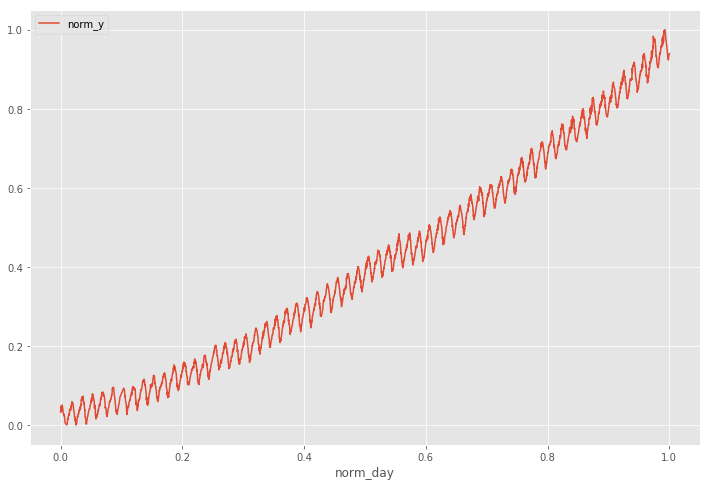

In [5]:
mauna_loa.plot(x='norm_day', y='norm_y', figsize=(12, 8))

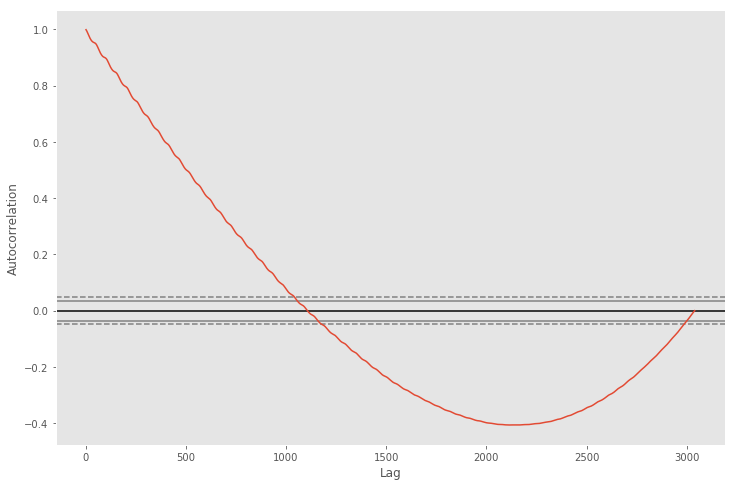

In [6]:
from pandas.plotting import autocorrelation_plot, lag_plot

fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(mauna_loa['norm_y'], ax)

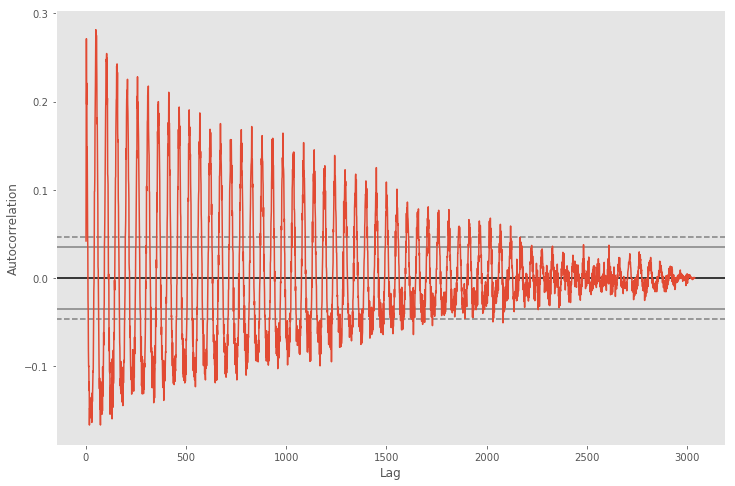

In [7]:
y_diffs = [y - x for x, y in zip(mauna_loa['norm_y'], mauna_loa['norm_y'][1:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(y_diffs, ax)

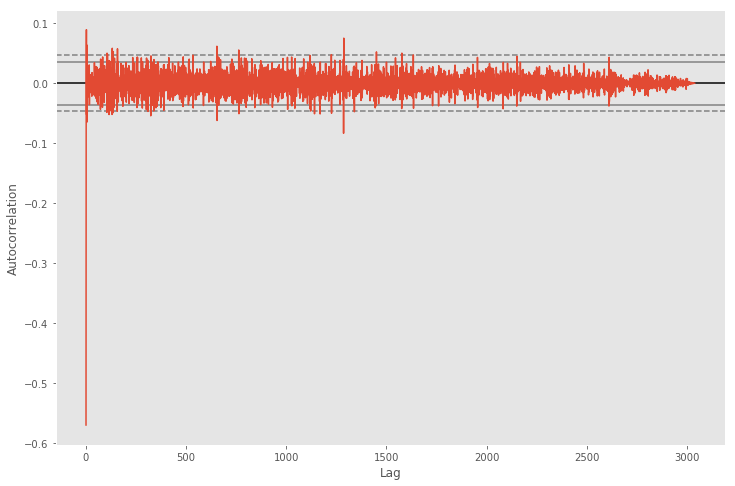

In [8]:
second_diffs = [y - x for x, y in zip(y_diffs, y_diffs[1:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(second_diffs, ax)

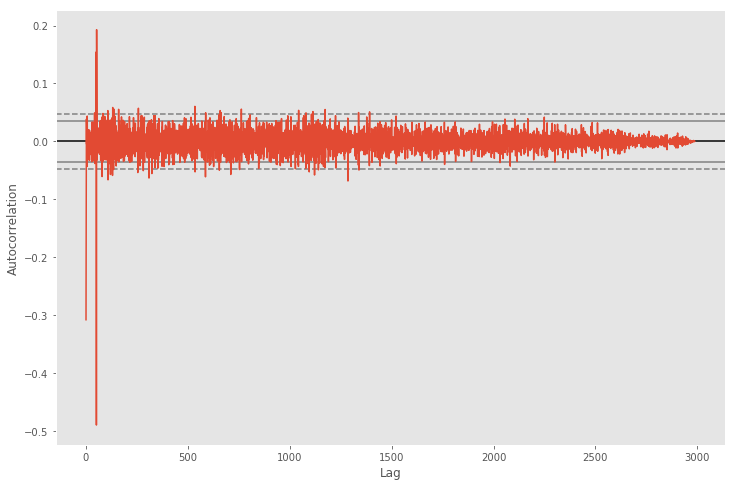

In [9]:
t_diffs = [y - x for x, y in zip(y_diffs, y_diffs[52:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(t_diffs, ax)

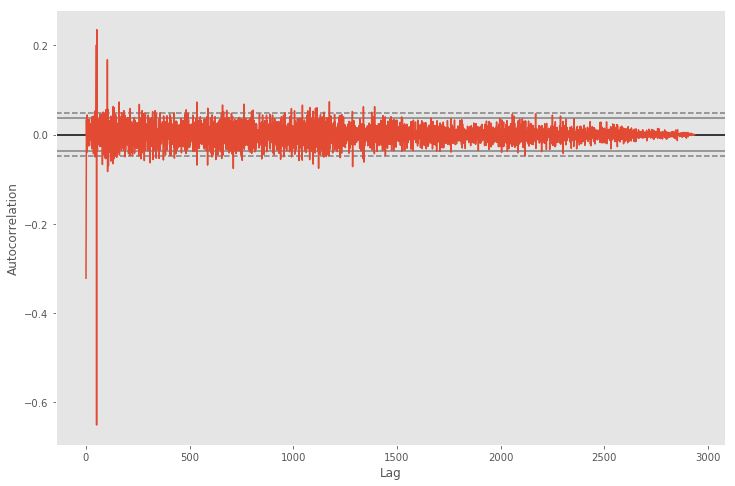

In [10]:
t2_diffs = [y - x for x, y in zip(t_diffs, t_diffs[52:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(t2_diffs, ax)

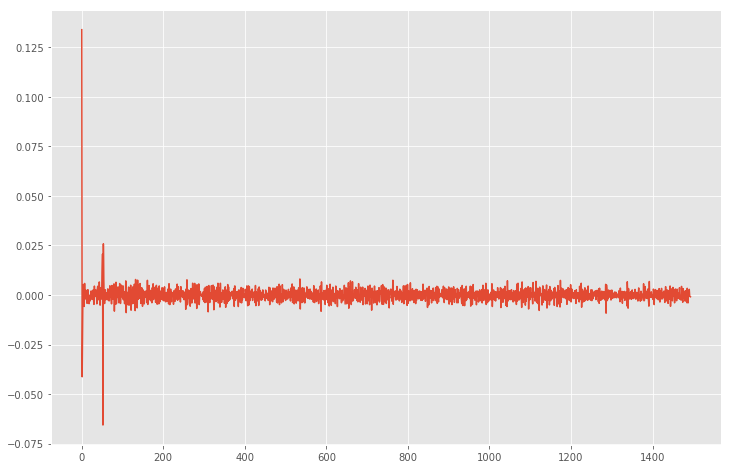

In [11]:
corr = np.correlate(t_diffs, t_diffs, 'same')
half_corr = corr[corr.shape[0] // 2:]
fig = plt.figure(figsize=(12, 8))
plt.plot(half_corr)

In [12]:
np.argmax(half_corr[1:])

52

/opt/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


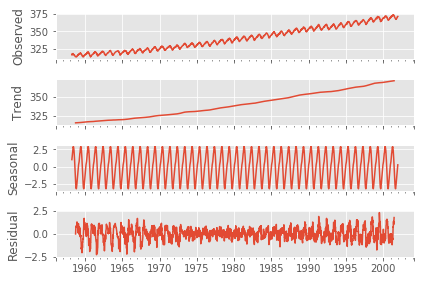

In [42]:
import statsmodels.api as sm

dta = sm.datasets.co2.load_pandas().data
# deal with missing values. see issue
dta.co2.interpolate(inplace=True)

res = sm.tsa.seasonal_decompose(dta.co2)

fig = plt.figure(figsize=(12, 8))
resplot = res.plot()

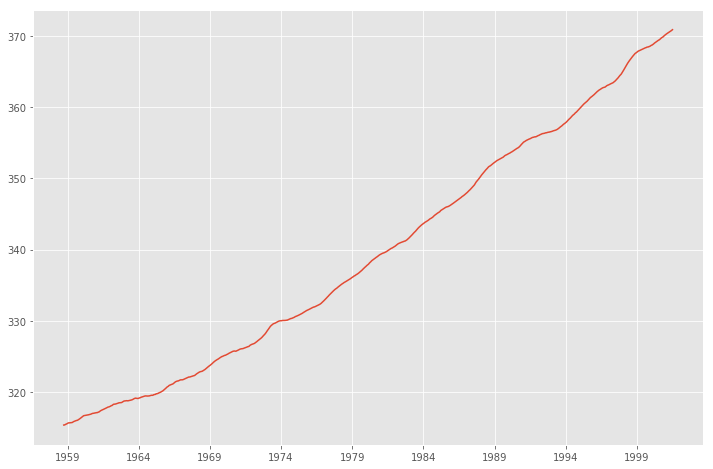

In [43]:
fig = plt.figure(figsize=(12, 8))
plt.plot(res.trend)

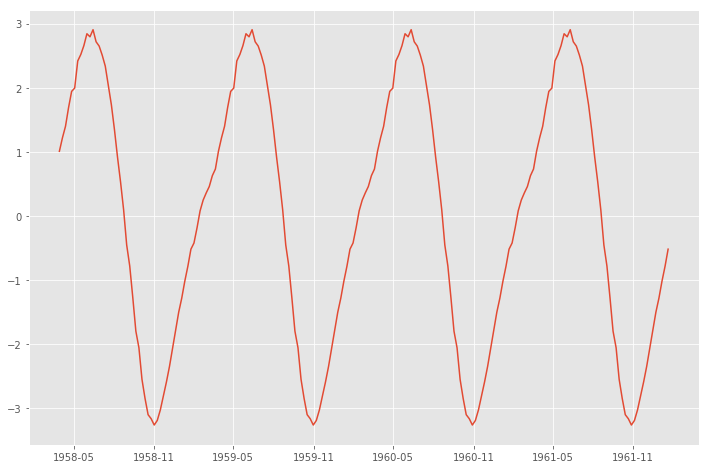

In [44]:
fig = plt.figure(figsize=(12, 8))
plt.plot(res.seasonal[:200])

## Start with a very naive Stan model 

In [ ]:
local_linear_model = """
data {
    int<lower=0> N; // number of data points
    int<lower=0> N_future; // number of 'future' test set data points
    vector[N] y;      // observed CO2 values
    vector[N] t;      // the days 
}

parameters {
    real alpha;    // linear regression intercept
    real beta;     // linear regression slope
    real<lower=0> sigma_lr; // linear regression slope
    real<lower=0, upper=1> rho;      // local trend learning rate

    real delta[N];               // slope at time t    
    real<lower=0> sigma_mu;      // standard deviation of the observation noise 
    real<lower=0> sigma_delta;   // standard deviation of the observation noise 
    
    // real mu;
    // real<lower=0> tau;
    
}
/*
transformed parameters {
    
    
    for (j in 1:J)
    theta[j] = mu + tau * eta[j];
}
*/

model {
    alpha ~ normal(0, 0.1);
    beta ~ normal(0, 0.1);
    sigma_lr ~ gamma(1, 0.1);
    rho ~ normal(0.1, 0.03);
    
    y ~ normal(alpha + t * beta, sigma_lr);

    sigma_delta ~ gamma(1, 0.1);
    sigma_mu ~ gamma(1, 0.1);

    delta[1] ~ normal(y[1], sigma_delta);
    y[1] ~ normal(delta[1], sigma_mu);
    
    for (i in 2:N) {
        delta[i] ~ normal(beta + rho * (delta[i - 1] - beta), sigma_delta);
        y[i] ~ normal(y[i - 1] + delta[i], sigma_mu);
    }
}

generated quantities {
  real delta_future[N_future];
  real y_future[N_future];
  
  delta_future[1] = normal_rng(delta[N], sigma_delta);
  y_future[1] = normal_rng(delta_future[1], sigma_mu);
  
  for(i in 2:N_future) {
    delta_future[i] = normal_rng(beta + rho * (delta_future[i - 1] - beta), sigma_delta);
    y_future[i] = normal_rng(y_future[i - 1] + delta_future[i], sigma_mu);
  }
}
"""

llm = pystan.StanModel(model_code=local_linear_model, model_name='local_linear', verbose=True)

In [ ]:
local_linear_data = {
    'N': len(train),
    'N_future': len(test),
    'y': train['norm_y'],
    't': train['norm_day'],
}

fit = llm.sampling(data=local_linear_data, iter=1000, chains=2, n_jobs=2, 
                  init=lambda: {'sigma_delta': 0.05, 'sigma_mu': 0.05, 'sigma_lr': 0.05, 'rho': 0.1,
                               'alpha': 0, 'beta': 0.1}
                  )

fit

In [ ]:
samples = fit.extract()

In [ ]:
def plot_samples(samples, future=100):
    delta_means = np.mean(samples['delta'], axis=0)
    delta_stds = np.std(samples['delta'], axis=0)
    noise = delta_stds + np.mean(samples['sigma_delta']) + np.mean(samples['sigma_mu'])
    y = [delta_means[0]]
    for d in delta_means[1:]:
        y.append(y[-1] + d)
        
    y = np.asarray(y)
        
    ax = mauna_loa.plot(x='norm_day', y='norm_y', figsize=(12, 8), color='black')
    ax.plot(train['norm_day'], y, color='red')
    ax.fill_between(train['norm_day'], y - 2 * noise, y + 2 * noise, alpha=0.4, 
                          facecolor='red')
    
    y_future_means = np.mean(samples['y_future'], axis=0)
    y_future_stds = np.std(samples['y_future'], axis=0)
    
    ax.plot(test['norm_day'][:future], y_future_means[:future], color='blue')
    ax.fill_between(test['norm_day'][:future], y_future_means[:future] - 2 * y_future_stds[:future], 
                    y_future_means[:future] + 2 * y_future_stds[:future], alpha=0.4, facecolor='blue')
    
    plt.show()

plot_samples(samples)

## This does not look promising. In the mean time, let's go for a different model

**TODO:**
* Compare different polynomial degrees
* Convert regression to feature vector
* Consider setting local slope as an MA rather than linear regression
* Importance sampling for model comparison?
* Triangular wave with steeper downwards slope?

In [22]:
# TRAIN_SIZE = 1040
# TEST_SIZE = 1040
# train = mauna_loa[:TRAIN_SIZE]
# test = mauna_loa[TRAIN_SIZE:TRAIN_SIZE + TEST_SIZE]

TEST_SIZE = 52 * 10
train = mauna_loa[:-TEST_SIZE]
test = mauna_loa[-TEST_SIZE:]
len(mauna_loa), len(train), len(test)

(3040, 2520, 520)

In [53]:

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2320, 1), (2320,), (200, 1), (200,))

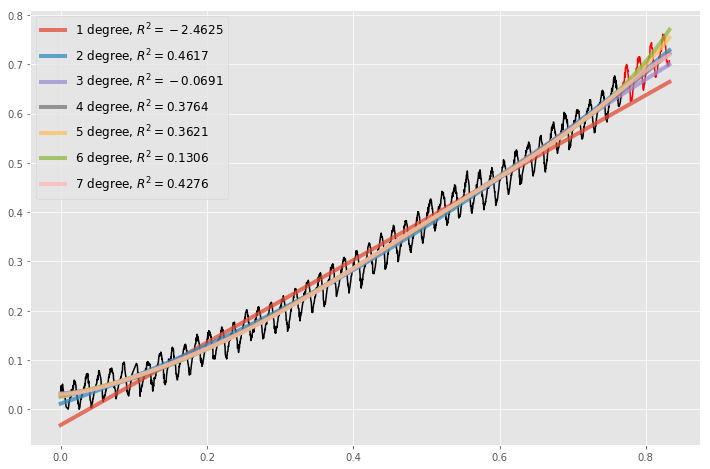

In [83]:
# adapted from http://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html

from sklearn.linear_model import Ridge, LassoLarsIC, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = np.asarray(train['norm_day']).reshape(-1, 1)
y = np.asarray(train['norm_y'])

X_train = X[:-200]
y_train = y[:-200]
X_test = X[-200:]
y_test = y[-200:]

fig = plt.figure(figsize=(12, 8))
plt.plot(X_train, y_train, color='black')
plt.plot(X_test, y_test, color='red')

for count, degree in enumerate(range(1, 8)):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression()) # LassoLarsIC(criterion='bic'))
    model.fit(X_train, y_train)
#     ic = np.sum(model.steps[1][1].criterion_)
    y_plot = model.predict(X)
    plt.plot(X, y_plot, lw=4, alpha=0.75,
             label='{d} degree, $R^2 = {r2:.4f}$'.format(d=degree, r2=model.score(X_test, y_test)))
#             label='{d} degree, $R^2 = {r2:.4f}$, ic = {ic:.3e}'.format(
#                 d=degree, r2=model.score(X_test, y_test), ic=ic))

plt.legend(loc=2, fontsize=12)

-104758.29591524755

In [84]:
sinuosdial_model = """
functions {
    vector poly_features(real t, int poly_deg) {
        vector[poly_deg] features;
        for (i in 1:poly_deg){
            features[i] = t ^ (i - 1);
        }
        return features;
    }

    /*
    real model_mean(real t_i) {
        return b_0 + b_1 * t_i + b_2 * (t_i ^ 2) + b_3 * (t_i ^ 3) + alpha * cos(unbound_omega * t_i + phi);
    }
    */
}


data {
    int<lower=0> N; // number of data points
    int<lower=0> N_future; // number of 'future' test set data points
    vector[N] y;      // observed CO2 values
    vector[N] t;      // the days
    vector[N_future] t_future;      // the days
    real unbound_omega_zero;  // the initial omega
    real unbound_alpha_zero;  // the initial alpha
    int<lower=1> poly_degree;
}

parameters {
    /*
    real b_0;    // linear regression intercept
    real b_1;     // linear regression slope
    real b_2;
    real b_3; 
    */
    vector[poly_degree] b;

    real unbound_omega; // the frequency parameter, in its unbound form
    // real phi;   // the phase shift parameter, in its unbound form
    real phi_x;
    real phi_y;
    real unbound_alpha; // the amplitude frequency in its unbound form
    real<lower=0> sigma_y; // overall prediction residual rror
}

transformed parameters {
    // real<lower=0> omega;
    // real<lower=0, upper=2 * pi()> phi;
    real phi;
    real<lower=0> alpha;
    
    // omega = exp(unbound_omega);
    // phi = 2 * pi() * inv_logit(unbound_phi);
    phi = atan2(phi_x, phi_y);
    alpha = exp(unbound_alpha);
}

model {
    // Priors
    /*
    b_0 ~ normal(0, 0.1);
    b_1 ~ normal(1, 0.25);
    b_2 ~ normal(1, 0.25);
    b_3 ~ normal(1, 0.25);
    */
    b[1] ~ normal(0, 0.1);
    for (i in 2:poly_degree) {
        b[i] ~ normal(1, 0.25);
    }
    
    phi_x ~ normal(0, 1);
    phi_y ~ normal(0, 1);
    
    unbound_omega ~ normal(unbound_omega_zero, 50);
    unbound_alpha ~ normal(unbound_alpha_zero, 1);
    sigma_y ~ gamma(1, 0.1);
    
    for (i in 1:N) {
        y[i] ~ normal(dot_product(b, poly_features(t[i], poly_degree)) + alpha * cos(unbound_omega * t[i] + phi), sigma_y);
    }
}

generated quantities {
  real y_future[N_future];
  
  for(i in 1:N_future) {
    y_future[i] = normal_rng(dot_product(b, poly_features(t_future[i], poly_degree)) + alpha * cos(unbound_omega * t_future[i] + phi), sigma_y);
  }
}
"""

sm = pystan.StanModel(model_code=sinuosdial_model, model_name='sinusodial_model', verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL sinusodial_model_352a0c5d1894e94ff8a5aeb396b507d5 NOW.
INFO:pystan:OS: linux, Python: 3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 12:22:00) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)], Cython 0.27.3


Compiling /tmp/tmp6f1rzz1r/stanfit4sinusodial_model_352a0c5d1894e94ff8a5aeb396b507d5_8052694545271170729.pyx because it changed.
[1/1] Cythonizing /tmp/tmp6f1rzz1r/stanfit4sinusodial_model_352a0c5d1894e94ff8a5aeb396b507d5_8052694545271170729.pyx
building 'stanfit4sinusodial_model_352a0c5d1894e94ff8a5aeb396b507d5_8052694545271170729' extension
creating /tmp/tmp6f1rzz1r/tmp
creating /tmp/tmp6f1rzz1r/tmp/tmp6f1rzz1r
gcc -pthread -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmp6f1rzz1r -I/opt/anaconda3/lib/python3.6/site-packages/pystan -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/src -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.64.0 -I/opt/anaconda3/lib/python3.6/site-packages/pystan

In [85]:
unbound_omega_zero = 2 * np.pi / (365.25 / day_range)
unbound_alpha_zero = -3

sinusodial_data = {
    'N': len(train),
    'N_future': len(test),
    'y': train['norm_y'],
    't': train['norm_day'],
    't_future': test['norm_day'],
    'unbound_omega_zero': unbound_omega_zero,
    'unbound_alpha_zero': unbound_alpha_zero,
    'poly_degree': 4
}

fit = sm.sampling(data=sinusodial_data, iter=1000, chains=8, n_jobs=8, 
                  init=lambda: {'b': [0, 1, 1, 1], # 'b_0': 0, 'b_1': 1, 'b_2': 1, 'b_3': 1,
                                'unbound_omega': unbound_omega_zero, 'unbound_phi': 0, 
                                'unbound_alpha': unbound_alpha_zero, 'sigma_y': 0.05, 
                               }
                  )

samples = fit.extract()
fit

Inference for Stan model: sinusodial_model_352a0c5d1894e94ff8a5aeb396b507d5.
8 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]            0.02  2.3e-5 7.8e-4   0.02   0.02   0.02   0.02   0.02   1128    nan
b[1]             0.4  2.3e-4 7.8e-3   0.38   0.39    0.4    0.4   0.41   1148   1.01
b[2]            0.74  7.2e-4   0.02    0.7   0.73   0.74   0.76   0.78    903   1.01
b[3]           -0.24  6.3e-4   0.02  -0.28  -0.26  -0.25  -0.23  -0.21    732   1.01
unbound_omega 374.64  8.1e-4   0.04 374.57 374.62 374.64 374.67 374.72   2190    1.0
phi_x          -0.62    0.01    0.3   -1.3  -0.81  -0.58  -0.39  -0.15    457   1.02
phi_y           1.15    0.03   0.56   0.27   0.71   1.08    1.5    2.4    452   1.02
unbound_alpha  -3.54  2.4e-4 8.8e-3  -3.56  -3.54  -3.54  -3.53  -3.52   1385   1.01
sigma_y       9.4e-3  2.6e-6 1.3e-4 9.1e-3

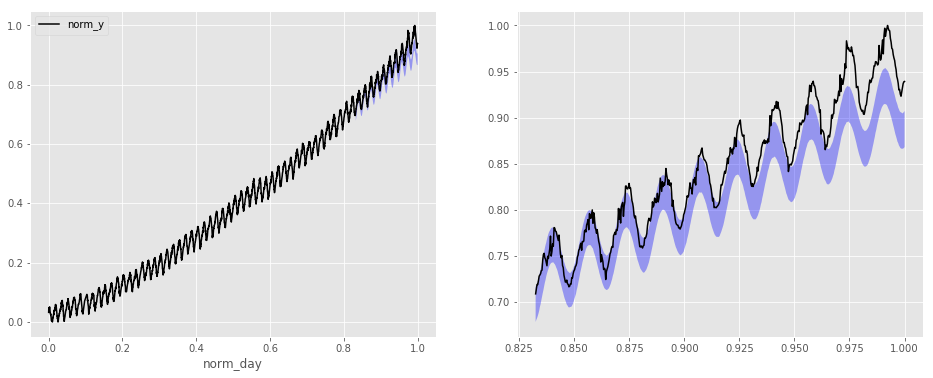

In [86]:
def plot_samples(samples, future=None):
    if future is None:
        future = len(test)
        
    fig = plt.figure(figsize=(16, 6))
    gs = gridspec.GridSpec(1, 2, hspace=0.7)

    y_future_means = np.mean(samples['y_future'], axis=0)
    y_future_stds = np.std(samples['y_future'], axis=0)

    left_ax = plt.subplot(gs[0, 0])
    mauna_loa.plot(x='norm_day', y='norm_y', color='black', ax=left_ax)
    left_ax.fill_between(test['norm_day'][:future], y_future_means[:future] - 2 * y_future_stds[:future], 
                    y_future_means[:future] + 2 * y_future_stds[:future], alpha=0.35, facecolor='blue')

    right_ax = plt.subplot(gs[0, 1])
    right_ax.plot(test['norm_day'][:future], test['norm_y'][:future], color='black')
    right_ax.fill_between(test['norm_day'][:future], y_future_means[:future] - 2 * y_future_stds[:future], 
                    y_future_means[:future] + 2 * y_future_stds[:future], alpha=0.35, facecolor='blue')
    
    plt.show()


plot_samples(samples)

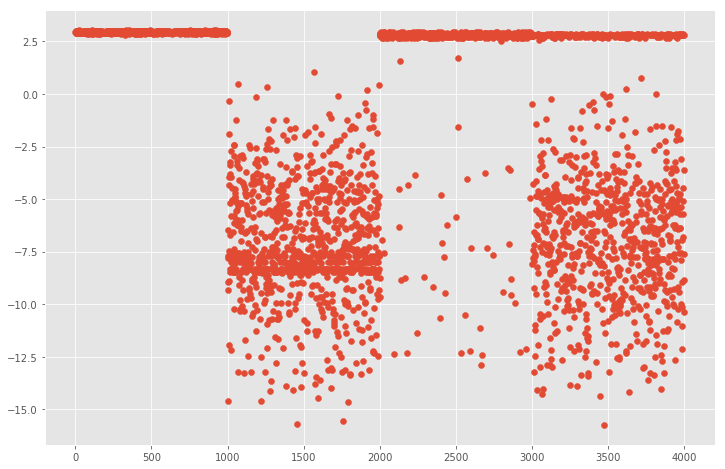

In [77]:
plt.figure(figsize=(12, 8))
plt.scatter(range(samples['unbound_omega'].shape[0]), samples['unbound_omega'])